In [31]:
# --- Standard libraries
import os.path as osp
import pandas as pd
import numpy as np
import pickle as pkl
# --- Matplotlib
import matplotlib.pyplot as plt
import imageio
# --- PyTorch and PyG
import torch
from torch_geometric.loader import DataLoader
# --- XASNet
from XASNet.data import QM9_XAS
from XASNet.data import save_split
from XASNet.models import XASNet_GNN, XASNet_GAT, XASNet_GraphNet
from XASNet.trainer import GNNTrainer

In [32]:
# --- Load in the dataset
root = './datasets/mol_dataset.pt'
go_spec = QM9_XAS(root=root,
                  raw_dir='./datasets/',
                  spectra=[])

In [33]:
# --- Print details of the dataset
print(go_spec)
print('------------')
print(f'Number of graphs: {len(go_spec)}')
print(f'Number of features: {go_spec.num_features}')
print('')

# --- Print details of the first molecule/graph in dataset
data = go_spec[0]

print(data)
print('------------')
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

QM9_XAS(317)
------------
Number of graphs: 317
Number of features: 15

Data(x=[32, 15], edge_index=[2, 76], edge_attr=[76, 6], spectrum=[200], pos=[32, 3], z=[32], idx=[1], smiles='c12[c:2]3[cH:1][cH:25][c:24]4[c:22]1[c:17]1[c:19]([cH:20][cH:23]4)[C:18]([C:21](=[O:26])[OH:27])=[CH:16][C:15]4=[CH:14][CH:12]=[C:11]5[C:9]([OH:30])([CH:4]2[C:6]([OH:31])([C:5]([C:8](=[O:28])[OH:29])=[CH:3]3)[CH:7]=[CH:10]5)[CH:13]41')
------------
Number of nodes: 32
Number of edges: 76
Average node degree: 2.38
Has isolated nodes: False
Has self loops: False
Is undirected: True


In [34]:
# --- Create spilt file with the dataset
# --- split into test, validation and test datasets
idxs = save_split(
    path='./datasets/xasnet-mol-split.npz',
    ndata=len(go_spec),
    ntrain=238,
    nval=29,
    ntest=48,
    save_split=True,
    shuffle=True, 
    print_nsample=True
)

In [35]:
# --- Create variables for each dataset split
train_go = [go_spec[i] for i in idxs['train']]
val_go = [go_spec[i] for i in idxs['val']]
test_go = [go_spec[i] for i in idxs['test']]

# --- Save datasets splits into dataloaders
train_loader = DataLoader(train_go, batch_size=238, shuffle=True)
val_loader = DataLoader(val_go, batch_size=29, shuffle=True)
test_loader = DataLoader(test_go, batch_size=48, shuffle=False)

print(f'Training dataset length: {len(train_go)}, compiled in {len(train_loader)} loaders')
print(f'Validation dataset length: {len(val_go)}, compiled in {len(val_loader)} loaders')
print(f'Test dataset length: {len(test_go)}, compiled in {len(test_loader)} loaders')

Training dataset length: 238, compiled in 1 loaders
Validation dataset length: 29, compiled in 1 loaders
Test dataset length: 48, compiled in 1 loaders


In [36]:
# --- Save the dataloader to a file
torch.save(test_go, './datasets/mol_test_dataset.pt')

In [37]:
# --- Define cost functions
def RSE_loss(prediction, target):
    dE = (300 - 280) / 200
    nom = torch.sum(dE*torch.pow((target-prediction), 2))
    denom = torch.sum(dE*target)
    return torch.sqrt(nom) / denom 

def RMSE_loss(prediction, target):
    return torch.sqrt(torch.mean((target - prediction)**2))

def MSE_loss(prediction, target):
    return torch.mean((target - prediction)**2)

In [38]:
# --- Set number of epochs to run
num_epochs = 300
# --- Set the learning rate 
lr = 0.001
# --- Milestones to reduce learning rate in steps 
milestones = np.arange(100, 900, 200).tolist()
print(milestones)

[100, 300, 500, 700]


##### XASNet GNN

In [39]:
# --- Set name for ML model
model_name = 'xasnet_gnn_model'

# --- Set device for model to run on
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# --- Create the type of ML model you want to run
xasnet_gnn = XASNet_GNN(
    gnn_name = 'gcn', # model type
    in_channels = [15, 64, 128, 256], # input nodes for each layer
    out_channels = [64, 128, 256, 512], # output nodes for each layer
    num_targets = 200, # nodes for final output
    num_layers = 4, # number of total layers
    heads = 0
).to(device)

# --- Location to save model
path_to_model = osp.join('./best_model,', model_name)

# --- Check if there is an already existing model
if osp.exists(path_to_model):
    xasnet_gnn.load_state_dict(torch.load(path_to_model))
else:
    print('Model is not loaded.')

Model is not loaded.


In [40]:
# --- View the details of the created model
print(xasnet_gnn)
print('----')
print(f' Model will be trained on: {device}')

XASNet_GNN(
  (batch_norms): ModuleList(
    (0): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (interaction_layers): ModuleList(
    (0): GCNConv(15, 64)
    (1): GCNConv(64, 128)
    (2): GCNConv(128, 256)
    (3): GCNConv(256, 512)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (out): Linear(in_features=512, out_features=200, bias=True)
)
----
 Model will be trained on: cpu


##### XASNet GAT

In [41]:
# --- Set name for ML model
model_name = 'xasnet_gat_model'

# --- Set device for model to run on
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# --- Create the type of ML model you want to run
xasnet_gat = XASNet_GAT(
    node_features_dim=15,
    in_channels=[128, 128, 128, 128],
    out_channels=[128, 128, 128, 400],
    targets=200,
    n_layers=4,
    n_heads=3,
    gat_type='gatv2_custom',
    use_residuals=True,
    use_jk=True
).to(device)

# --- Location to save model
path_to_model = osp.join('./best_model,', model_name)

# --- Check if there is an already existing model
if osp.exists(path_to_model):
    xasnet_gat.load_state_dict(torch.load(path_to_model))
else:
    print('Model is not loaded.')

Model is not loaded.


In [42]:
# --- View the details of the created model
print(xasnet_gat)
print('----')
print(f' Model will be trained on: {device}')

XASNet_GAT(
  (pre_layer): LinearLayer(
    (linear): Linear(in_features=15, out_features=128, bias=False)
    (_activation): ReLU(inplace=True)
  )
  (res_block): Residual_block(
    (res_layers): Sequential(
      (0): LinearLayer(
        (linear): Linear(in_features=128, out_features=128, bias=False)
        (_activation): ReLU(inplace=True)
      )
      (1): LinearLayer(
        (linear): Linear(in_features=128, out_features=128, bias=False)
        (_activation): ReLU(inplace=True)
      )
      (2): LinearLayer(
        (linear): Linear(in_features=128, out_features=128, bias=False)
        (_activation): ReLU(inplace=True)
      )
      (3): LinearLayer(
        (linear): Linear(in_features=128, out_features=128, bias=False)
        (_activation): ReLU(inplace=True)
      )
    )
  )
  (gat_layers): ModuleList(
    (0): GATv2LayerCus(128, 128)
    (1): ReLU(inplace=True)
    (2): GATv2LayerCus(384, 128)
    (3): ReLU(inplace=True)
    (4): GATv2LayerCus(384, 128)
    (5): ReLU

##### XASNet GraphNet

In [43]:
# --- Set name for ML model
model_name = 'xasnet_graphnet_model'

# --- Set device for model to run on
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# --- Create the type of ML model you want to run
xasnet_graphnet = XASNet_GraphNet(
    node_dim=15,
    edge_dim=6,
    hidden_channels=512,
    out_channels=200,
    gat_hidd=512,
    gat_out=200,
    n_layers=3,
    n_targets=200
).to(device)

# --- Location to save model
path_to_model = osp.join('./best_model,', model_name)

# --- Check if there is an already existing model
if osp.exists(path_to_model):
    xasnet_graphnet.load_state_dict(torch.load(path_to_model))
else:
    print('Model is not loaded.')

Model is not loaded.


In [44]:
# --- View the details of the created model
print(xasnet_graphnet)
print('----')
print(f' Model will be trained on: {device}')

XASNet_GraphNet(
  (graphnets): ModuleList(
    (0): GraphNetwork(
      (gatencoder): GATEncoder(
        (gats): ModuleList(
          (0): GATv2Conv(15, 512, heads=3)
          (1): ReLU(inplace=True)
          (2): GATv2Conv(1536, 512, heads=3)
          (3): ReLU(inplace=True)
          (4): GATv2Conv(1536, 512, heads=3)
          (5): ReLU(inplace=True)
          (6): GATv2Conv(1536, 200, heads=1)
        )
      )
      (node_model): NodeModel(
        (mlp): Sequential(
          (0): Linear(in_features=227, out_features=512, bias=True)
          (1): ReLU(inplace=True)
          (2): Linear(in_features=512, out_features=200, bias=True)
          (3): ReLU(inplace=True)
          (4): LayerNorm((200,), eps=1e-05, elementwise_affine=True)
        )
      )
      (edge_model): EdgeModel(
        (mlp): Sequential(
          (0): Linear(in_features=606, out_features=512, bias=True)
          (1): ReLU(inplace=True)
          (2): Linear(in_features=512, out_features=200, bias=True

##### Train model

In [45]:
chosen_model = xasnet_gnn
model_name = 'xasnet_gnn_model'

In [46]:
# --- Set additional ML parameters
optimizer = torch.optim.Adam(chosen_model.parameters(), lr=lr, weight_decay=1e-5, betas=(0.9, 0.99), eps=1e-08, amsgrad=True)

#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=0.8)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=100, min_lr=0.000001)

In [47]:
# --- Create trainier
trainer = GNNTrainer(model = chosen_model,
                     model_name = model_name,
                     device = device,
                     metric_path = './metrics/' + model_name)

In [48]:
# --- Train the ML model
trainer.train_val(train_loader, val_loader, optimizer, MSE_loss,
                  scheduler, num_epochs, write_every=2, train_graphnet=False)

  1%|          | 2/300 [00:00<00:49,  6.01it/s]

epoch 0 | average train loss = 0.25761 and average validation loss = 0.30148 | learning rate = 0.00100


  1%|▏         | 4/300 [00:00<00:42,  6.89it/s]

epoch 2 | average train loss = 0.24220 and average validation loss = 0.27945 | learning rate = 0.00100


  2%|▏         | 6/300 [00:00<00:40,  7.32it/s]

epoch 4 | average train loss = 0.23237 and average validation loss = 0.24858 | learning rate = 0.00100


  3%|▎         | 8/300 [00:01<00:41,  6.96it/s]

epoch 6 | average train loss = 0.22691 and average validation loss = 0.21224 | learning rate = 0.00100


  3%|▎         | 10/300 [00:01<00:36,  7.90it/s]

epoch 8 | average train loss = 0.22148 and average validation loss = 0.17274 | learning rate = 0.00100


  4%|▍         | 12/300 [00:01<00:34,  8.25it/s]

epoch 10 | average train loss = 0.21457 and average validation loss = 0.13316 | learning rate = 0.00100


  5%|▍         | 14/300 [00:01<00:35,  8.02it/s]

epoch 12 | average train loss = 0.21027 and average validation loss = 0.09941 | learning rate = 0.00100


  5%|▌         | 16/300 [00:02<00:36,  7.68it/s]

epoch 14 | average train loss = 0.20270 and average validation loss = 0.07728 | learning rate = 0.00100


  6%|▌         | 18/300 [00:02<00:36,  7.71it/s]

epoch 16 | average train loss = 0.19665 and average validation loss = 0.07058 | learning rate = 0.00100


  7%|▋         | 20/300 [00:02<00:36,  7.72it/s]

epoch 18 | average train loss = 0.19078 and average validation loss = 0.07690 | learning rate = 0.00100


  7%|▋         | 22/300 [00:02<00:36,  7.55it/s]

epoch 20 | average train loss = 0.18369 and average validation loss = 0.09001 | learning rate = 0.00100


  8%|▊         | 23/300 [00:03<00:38,  7.18it/s]

epoch 22 | average train loss = 0.17690 and average validation loss = 0.10217 | learning rate = 0.00100


  9%|▊         | 26/300 [00:03<00:44,  6.18it/s]

epoch 24 | average train loss = 0.17090 and average validation loss = 0.10981 | learning rate = 0.00100


  9%|▉         | 28/300 [00:03<00:43,  6.30it/s]

epoch 26 | average train loss = 0.16121 and average validation loss = 0.11145 | learning rate = 0.00100


 10%|▉         | 29/300 [00:04<00:50,  5.41it/s]

epoch 28 | average train loss = 0.15529 and average validation loss = 0.10752 | learning rate = 0.00100


 10%|█         | 31/300 [00:04<00:56,  4.73it/s]

epoch 30 | average train loss = 0.14911 and average validation loss = 0.09872 | learning rate = 0.00100


 11%|█▏        | 34/300 [00:05<00:56,  4.74it/s]

epoch 32 | average train loss = 0.14129 and average validation loss = 0.08734 | learning rate = 0.00100


 12%|█▏        | 35/300 [00:05<00:57,  4.60it/s]

epoch 34 | average train loss = 0.13573 and average validation loss = 0.07537 | learning rate = 0.00100


 12%|█▏        | 37/300 [00:06<01:00,  4.36it/s]

epoch 36 | average train loss = 0.12982 and average validation loss = 0.06446 | learning rate = 0.00100


 13%|█▎        | 39/300 [00:06<01:00,  4.35it/s]

epoch 38 | average train loss = 0.12077 and average validation loss = 0.05366 | learning rate = 0.00100


 14%|█▍        | 42/300 [00:07<00:58,  4.42it/s]

epoch 40 | average train loss = 0.11372 and average validation loss = 0.04478 | learning rate = 0.00100


 14%|█▍        | 43/300 [00:07<00:59,  4.35it/s]

epoch 42 | average train loss = 0.10340 and average validation loss = 0.04212 | learning rate = 0.00100


 15%|█▌        | 45/300 [00:07<01:00,  4.22it/s]

epoch 44 | average train loss = 0.09928 and average validation loss = 0.04435 | learning rate = 0.00100


 16%|█▌        | 47/300 [00:08<00:58,  4.36it/s]

epoch 46 | average train loss = 0.08421 and average validation loss = 0.05782 | learning rate = 0.00100


 16%|█▋        | 49/300 [00:08<01:08,  3.64it/s]

epoch 48 | average train loss = 0.07253 and average validation loss = 0.07375 | learning rate = 0.00100


 17%|█▋        | 51/300 [00:09<01:15,  3.31it/s]

epoch 50 | average train loss = 0.06124 and average validation loss = 0.07031 | learning rate = 0.00100


 18%|█▊        | 53/300 [00:10<01:17,  3.19it/s]

epoch 52 | average train loss = 0.05138 and average validation loss = 0.06726 | learning rate = 0.00100


 18%|█▊        | 55/300 [00:10<01:17,  3.15it/s]

epoch 54 | average train loss = 0.04330 and average validation loss = 0.07274 | learning rate = 0.00100


 19%|█▉        | 58/300 [00:11<01:06,  3.63it/s]

epoch 56 | average train loss = 0.04138 and average validation loss = 0.05444 | learning rate = 0.00100


 20%|█▉        | 59/300 [00:11<01:03,  3.80it/s]

epoch 58 | average train loss = 0.04202 and average validation loss = 0.03631 | learning rate = 0.00100


 20%|██        | 61/300 [00:12<01:03,  3.75it/s]

epoch 60 | average train loss = 0.04122 and average validation loss = 0.02445 | learning rate = 0.00100


 21%|██        | 63/300 [00:13<01:05,  3.60it/s]

epoch 62 | average train loss = 0.03891 and average validation loss = 0.01884 | learning rate = 0.00100


 22%|██▏       | 65/300 [00:13<01:01,  3.84it/s]

epoch 64 | average train loss = 0.03739 and average validation loss = 0.01639 | learning rate = 0.00100


 22%|██▏       | 67/300 [00:14<00:59,  3.92it/s]

epoch 66 | average train loss = 0.03504 and average validation loss = 0.01736 | learning rate = 0.00100


 23%|██▎       | 69/300 [00:14<00:58,  3.96it/s]

epoch 68 | average train loss = 0.03315 and average validation loss = 0.01397 | learning rate = 0.00100


 24%|██▎       | 71/300 [00:14<00:57,  4.01it/s]

epoch 70 | average train loss = 0.03232 and average validation loss = 0.01405 | learning rate = 0.00100


 24%|██▍       | 73/300 [00:15<00:57,  3.96it/s]

epoch 72 | average train loss = 0.03236 and average validation loss = 0.01627 | learning rate = 0.00100


 25%|██▌       | 75/300 [00:16<00:57,  3.88it/s]

epoch 74 | average train loss = 0.03269 and average validation loss = 0.01694 | learning rate = 0.00100


 26%|██▌       | 77/300 [00:16<00:55,  4.02it/s]

epoch 76 | average train loss = 0.03188 and average validation loss = 0.01400 | learning rate = 0.00100


 26%|██▋       | 79/300 [00:16<00:54,  4.06it/s]

epoch 78 | average train loss = 0.03077 and average validation loss = 0.01367 | learning rate = 0.00100


 27%|██▋       | 81/300 [00:17<00:50,  4.30it/s]

epoch 80 | average train loss = 0.03077 and average validation loss = 0.01338 | learning rate = 0.00100


 28%|██▊       | 83/300 [00:17<00:52,  4.11it/s]

epoch 82 | average train loss = 0.03027 and average validation loss = 0.01212 | learning rate = 0.00100


 28%|██▊       | 85/300 [00:18<00:54,  3.98it/s]

epoch 84 | average train loss = 0.03106 and average validation loss = 0.01161 | learning rate = 0.00100


 29%|██▉       | 87/300 [00:18<00:52,  4.07it/s]

epoch 86 | average train loss = 0.02843 and average validation loss = 0.01113 | learning rate = 0.00100


 30%|██▉       | 89/300 [00:19<00:52,  3.99it/s]

epoch 88 | average train loss = 0.02897 and average validation loss = 0.01046 | learning rate = 0.00100


 30%|███       | 91/300 [00:19<00:53,  3.91it/s]

epoch 90 | average train loss = 0.02909 and average validation loss = 0.01023 | learning rate = 0.00100


 31%|███       | 93/300 [00:20<00:59,  3.51it/s]

epoch 92 | average train loss = 0.02866 and average validation loss = 0.01027 | learning rate = 0.00100


 32%|███▏      | 95/300 [00:21<01:02,  3.26it/s]

epoch 94 | average train loss = 0.02837 and average validation loss = 0.01065 | learning rate = 0.00100


 32%|███▏      | 97/300 [00:21<01:09,  2.94it/s]

epoch 96 | average train loss = 0.02944 and average validation loss = 0.00980 | learning rate = 0.00100


 33%|███▎      | 99/300 [00:22<01:07,  2.96it/s]

epoch 98 | average train loss = 0.02812 and average validation loss = 0.00985 | learning rate = 0.00100


 34%|███▎      | 101/300 [00:23<00:55,  3.58it/s]

epoch 100 | average train loss = 0.02643 and average validation loss = 0.01012 | learning rate = 0.00100


 34%|███▍      | 103/300 [00:23<00:57,  3.46it/s]

epoch 102 | average train loss = 0.02721 and average validation loss = 0.01015 | learning rate = 0.00100


 35%|███▌      | 105/300 [00:24<00:57,  3.37it/s]

epoch 104 | average train loss = 0.02660 and average validation loss = 0.00994 | learning rate = 0.00100


 36%|███▌      | 107/300 [00:24<00:53,  3.62it/s]

epoch 106 | average train loss = 0.02427 and average validation loss = 0.01019 | learning rate = 0.00100


 36%|███▋      | 109/300 [00:25<00:46,  4.08it/s]

epoch 108 | average train loss = 0.02523 and average validation loss = 0.01007 | learning rate = 0.00100


 37%|███▋      | 111/300 [00:25<00:44,  4.23it/s]

epoch 110 | average train loss = 0.02561 and average validation loss = 0.01028 | learning rate = 0.00100


 38%|███▊      | 113/300 [00:26<00:44,  4.24it/s]

epoch 112 | average train loss = 0.02687 and average validation loss = 0.01048 | learning rate = 0.00100


 38%|███▊      | 115/300 [00:26<00:44,  4.17it/s]

epoch 114 | average train loss = 0.02542 and average validation loss = 0.01017 | learning rate = 0.00100


 39%|███▉      | 117/300 [00:27<00:44,  4.14it/s]

epoch 116 | average train loss = 0.02584 and average validation loss = 0.01004 | learning rate = 0.00100


 40%|███▉      | 119/300 [00:27<00:42,  4.21it/s]

epoch 118 | average train loss = 0.02546 and average validation loss = 0.01034 | learning rate = 0.00100


 40%|████      | 121/300 [00:28<00:41,  4.33it/s]

epoch 120 | average train loss = 0.02462 and average validation loss = 0.01019 | learning rate = 0.00100


 41%|████      | 123/300 [00:28<00:42,  4.20it/s]

epoch 122 | average train loss = 0.02539 and average validation loss = 0.01041 | learning rate = 0.00100


 42%|████▏     | 125/300 [00:28<00:41,  4.19it/s]

epoch 124 | average train loss = 0.02464 and average validation loss = 0.01003 | learning rate = 0.00100


 42%|████▏     | 127/300 [00:29<00:40,  4.22it/s]

epoch 126 | average train loss = 0.02510 and average validation loss = 0.00983 | learning rate = 0.00100


 43%|████▎     | 129/300 [00:29<00:44,  3.88it/s]

epoch 128 | average train loss = 0.02484 and average validation loss = 0.00977 | learning rate = 0.00100


 44%|████▎     | 131/300 [00:30<00:49,  3.44it/s]

epoch 130 | average train loss = 0.02362 and average validation loss = 0.00978 | learning rate = 0.00100


 44%|████▍     | 133/300 [00:31<00:47,  3.48it/s]

epoch 132 | average train loss = 0.02478 and average validation loss = 0.00948 | learning rate = 0.00100


 45%|████▌     | 135/300 [00:31<00:47,  3.48it/s]

epoch 134 | average train loss = 0.02374 and average validation loss = 0.00925 | learning rate = 0.00100


 46%|████▌     | 137/300 [00:32<00:47,  3.46it/s]

epoch 136 | average train loss = 0.02332 and average validation loss = 0.00950 | learning rate = 0.00100


 46%|████▋     | 139/300 [00:32<00:43,  3.73it/s]

epoch 138 | average train loss = 0.02347 and average validation loss = 0.00953 | learning rate = 0.00100


 47%|████▋     | 141/300 [00:33<00:39,  4.05it/s]

epoch 140 | average train loss = 0.02337 and average validation loss = 0.00938 | learning rate = 0.00100


 48%|████▊     | 143/300 [00:33<00:38,  4.07it/s]

epoch 142 | average train loss = 0.02264 and average validation loss = 0.00926 | learning rate = 0.00100


 48%|████▊     | 145/300 [00:34<00:37,  4.14it/s]

epoch 144 | average train loss = 0.02209 and average validation loss = 0.00924 | learning rate = 0.00100


 49%|████▉     | 147/300 [00:34<00:36,  4.15it/s]

epoch 146 | average train loss = 0.02299 and average validation loss = 0.00912 | learning rate = 0.00100


 50%|████▉     | 149/300 [00:35<00:36,  4.18it/s]

epoch 148 | average train loss = 0.02202 and average validation loss = 0.00898 | learning rate = 0.00100


 50%|█████     | 151/300 [00:35<00:35,  4.23it/s]

epoch 150 | average train loss = 0.02173 and average validation loss = 0.00900 | learning rate = 0.00100


 51%|█████     | 153/300 [00:36<00:36,  4.07it/s]

epoch 152 | average train loss = 0.02127 and average validation loss = 0.00891 | learning rate = 0.00100


 52%|█████▏    | 155/300 [00:36<00:38,  3.79it/s]

epoch 154 | average train loss = 0.02297 and average validation loss = 0.00874 | learning rate = 0.00100


 52%|█████▏    | 157/300 [00:37<00:42,  3.39it/s]

epoch 156 | average train loss = 0.02205 and average validation loss = 0.00893 | learning rate = 0.00100


 53%|█████▎    | 159/300 [00:38<00:43,  3.24it/s]

epoch 158 | average train loss = 0.02204 and average validation loss = 0.00888 | learning rate = 0.00100


 54%|█████▎    | 161/300 [00:38<00:43,  3.23it/s]

epoch 160 | average train loss = 0.02225 and average validation loss = 0.00904 | learning rate = 0.00100


 54%|█████▍    | 163/300 [00:39<00:41,  3.34it/s]

epoch 162 | average train loss = 0.02128 and average validation loss = 0.00907 | learning rate = 0.00100


 55%|█████▌    | 165/300 [00:39<00:36,  3.73it/s]

epoch 164 | average train loss = 0.02205 and average validation loss = 0.00921 | learning rate = 0.00100


 56%|█████▌    | 167/300 [00:40<00:33,  3.99it/s]

epoch 166 | average train loss = 0.02182 and average validation loss = 0.00897 | learning rate = 0.00100


 56%|█████▋    | 169/300 [00:40<00:31,  4.18it/s]

epoch 168 | average train loss = 0.02076 and average validation loss = 0.00898 | learning rate = 0.00100


 57%|█████▋    | 171/300 [00:41<00:31,  4.16it/s]

epoch 170 | average train loss = 0.02022 and average validation loss = 0.00893 | learning rate = 0.00100


 58%|█████▊    | 173/300 [00:41<00:30,  4.18it/s]

epoch 172 | average train loss = 0.01977 and average validation loss = 0.00870 | learning rate = 0.00100


 58%|█████▊    | 175/300 [00:42<00:30,  4.08it/s]

epoch 174 | average train loss = 0.01982 and average validation loss = 0.00901 | learning rate = 0.00100


 59%|█████▉    | 177/300 [00:42<00:29,  4.15it/s]

epoch 176 | average train loss = 0.02013 and average validation loss = 0.00924 | learning rate = 0.00100


 60%|█████▉    | 179/300 [00:43<00:29,  4.12it/s]

epoch 178 | average train loss = 0.01971 and average validation loss = 0.00875 | learning rate = 0.00100


 61%|██████    | 182/300 [00:43<00:28,  4.21it/s]

epoch 180 | average train loss = 0.01979 and average validation loss = 0.00893 | learning rate = 0.00100


 61%|██████    | 183/300 [00:43<00:27,  4.19it/s]

epoch 182 | average train loss = 0.02082 and average validation loss = 0.00885 | learning rate = 0.00100


 62%|██████▏   | 185/300 [00:44<00:28,  3.98it/s]

epoch 184 | average train loss = 0.02005 and average validation loss = 0.00950 | learning rate = 0.00100


 62%|██████▏   | 187/300 [00:44<00:28,  4.02it/s]

epoch 186 | average train loss = 0.02035 and average validation loss = 0.00891 | learning rate = 0.00100


 63%|██████▎   | 189/300 [00:45<00:26,  4.14it/s]

epoch 188 | average train loss = 0.01949 and average validation loss = 0.00881 | learning rate = 0.00100


 64%|██████▎   | 191/300 [00:46<00:30,  3.62it/s]

epoch 190 | average train loss = 0.01895 and average validation loss = 0.00902 | learning rate = 0.00100


 64%|██████▍   | 193/300 [00:46<00:33,  3.22it/s]

epoch 192 | average train loss = 0.01998 and average validation loss = 0.00907 | learning rate = 0.00100


 65%|██████▌   | 195/300 [00:47<00:30,  3.43it/s]

epoch 194 | average train loss = 0.01901 and average validation loss = 0.00890 | learning rate = 0.00100


 66%|██████▌   | 197/300 [00:47<00:30,  3.41it/s]

epoch 196 | average train loss = 0.01900 and average validation loss = 0.00878 | learning rate = 0.00100


 66%|██████▋   | 199/300 [00:48<00:31,  3.17it/s]

epoch 198 | average train loss = 0.02009 and average validation loss = 0.00902 | learning rate = 0.00100


 67%|██████▋   | 201/300 [00:49<00:30,  3.26it/s]

epoch 200 | average train loss = 0.01941 and average validation loss = 0.00911 | learning rate = 0.00100


 68%|██████▊   | 203/300 [00:49<00:26,  3.61it/s]

epoch 202 | average train loss = 0.01887 and average validation loss = 0.00895 | learning rate = 0.00100


 68%|██████▊   | 205/300 [00:50<00:23,  3.97it/s]

epoch 204 | average train loss = 0.01860 and average validation loss = 0.00891 | learning rate = 0.00100


 69%|██████▉   | 207/300 [00:50<00:23,  4.03it/s]

epoch 206 | average train loss = 0.01833 and average validation loss = 0.00881 | learning rate = 0.00100


 70%|██████▉   | 209/300 [00:51<00:24,  3.77it/s]

epoch 208 | average train loss = 0.01818 and average validation loss = 0.00872 | learning rate = 0.00100


 70%|███████   | 211/300 [00:51<00:22,  3.95it/s]

epoch 210 | average train loss = 0.01783 and average validation loss = 0.00875 | learning rate = 0.00100


 71%|███████   | 213/300 [00:52<00:22,  3.84it/s]

epoch 212 | average train loss = 0.01769 and average validation loss = 0.00857 | learning rate = 0.00100


 72%|███████▏  | 215/300 [00:52<00:21,  4.00it/s]

epoch 214 | average train loss = 0.01842 and average validation loss = 0.00862 | learning rate = 0.00100


 72%|███████▏  | 217/300 [00:53<00:19,  4.23it/s]

epoch 216 | average train loss = 0.01857 and average validation loss = 0.00866 | learning rate = 0.00100


 73%|███████▎  | 220/300 [00:53<00:18,  4.31it/s]

epoch 218 | average train loss = 0.01721 and average validation loss = 0.00866 | learning rate = 0.00100


 74%|███████▎  | 221/300 [00:53<00:18,  4.33it/s]

epoch 220 | average train loss = 0.01721 and average validation loss = 0.00872 | learning rate = 0.00100


 74%|███████▍  | 223/300 [00:54<00:19,  4.02it/s]

epoch 222 | average train loss = 0.01800 and average validation loss = 0.00867 | learning rate = 0.00100


 75%|███████▌  | 225/300 [00:55<00:20,  3.67it/s]

epoch 224 | average train loss = 0.01717 and average validation loss = 0.00869 | learning rate = 0.00100


 76%|███████▌  | 227/300 [00:55<00:21,  3.40it/s]

epoch 226 | average train loss = 0.01799 and average validation loss = 0.00860 | learning rate = 0.00100


 76%|███████▋  | 229/300 [00:56<00:20,  3.43it/s]

epoch 228 | average train loss = 0.01786 and average validation loss = 0.00867 | learning rate = 0.00100


 77%|███████▋  | 231/300 [00:56<00:20,  3.43it/s]

epoch 230 | average train loss = 0.01782 and average validation loss = 0.00864 | learning rate = 0.00100


 78%|███████▊  | 233/300 [00:57<00:19,  3.46it/s]

epoch 232 | average train loss = 0.01691 and average validation loss = 0.00869 | learning rate = 0.00100


 78%|███████▊  | 235/300 [00:57<00:17,  3.82it/s]

epoch 234 | average train loss = 0.01712 and average validation loss = 0.00874 | learning rate = 0.00100


 79%|███████▉  | 237/300 [00:58<00:15,  4.01it/s]

epoch 236 | average train loss = 0.01763 and average validation loss = 0.00860 | learning rate = 0.00100


 80%|███████▉  | 239/300 [00:58<00:15,  3.98it/s]

epoch 238 | average train loss = 0.01694 and average validation loss = 0.00838 | learning rate = 0.00100


 80%|████████  | 241/300 [00:59<00:15,  3.86it/s]

epoch 240 | average train loss = 0.01741 and average validation loss = 0.00841 | learning rate = 0.00100


 81%|████████  | 243/300 [00:59<00:14,  4.05it/s]

epoch 242 | average train loss = 0.01778 and average validation loss = 0.00850 | learning rate = 0.00100


 82%|████████▏ | 245/300 [01:00<00:13,  4.00it/s]

epoch 244 | average train loss = 0.01628 and average validation loss = 0.00884 | learning rate = 0.00100


 82%|████████▏ | 247/300 [01:00<00:13,  4.00it/s]

epoch 246 | average train loss = 0.01687 and average validation loss = 0.00867 | learning rate = 0.00100


 83%|████████▎ | 249/300 [01:01<00:12,  4.09it/s]

epoch 248 | average train loss = 0.01587 and average validation loss = 0.00850 | learning rate = 0.00100


 84%|████████▎ | 251/300 [01:01<00:13,  3.67it/s]

epoch 250 | average train loss = 0.01683 and average validation loss = 0.00859 | learning rate = 0.00100


 84%|████████▍ | 253/300 [01:02<00:13,  3.52it/s]

epoch 252 | average train loss = 0.01601 and average validation loss = 0.00879 | learning rate = 0.00100


 85%|████████▌ | 255/300 [01:03<00:13,  3.33it/s]

epoch 254 | average train loss = 0.01668 and average validation loss = 0.00849 | learning rate = 0.00100


 86%|████████▌ | 257/300 [01:03<00:12,  3.33it/s]

epoch 256 | average train loss = 0.01666 and average validation loss = 0.00818 | learning rate = 0.00100


 86%|████████▋ | 259/300 [01:04<00:11,  3.72it/s]

epoch 258 | average train loss = 0.01614 and average validation loss = 0.00839 | learning rate = 0.00100


 87%|████████▋ | 261/300 [01:04<00:10,  3.81it/s]

epoch 260 | average train loss = 0.01621 and average validation loss = 0.00868 | learning rate = 0.00100


 88%|████████▊ | 263/300 [01:05<00:09,  4.01it/s]

epoch 262 | average train loss = 0.01572 and average validation loss = 0.00909 | learning rate = 0.00100


 88%|████████▊ | 265/300 [01:05<00:08,  4.00it/s]

epoch 264 | average train loss = 0.01555 and average validation loss = 0.00861 | learning rate = 0.00100


 89%|████████▉ | 267/300 [01:06<00:08,  4.02it/s]

epoch 266 | average train loss = 0.01569 and average validation loss = 0.00872 | learning rate = 0.00100


 90%|████████▉ | 269/300 [01:06<00:07,  3.98it/s]

epoch 268 | average train loss = 0.01510 and average validation loss = 0.00853 | learning rate = 0.00100


 90%|█████████ | 271/300 [01:07<00:07,  3.72it/s]

epoch 270 | average train loss = 0.01563 and average validation loss = 0.00862 | learning rate = 0.00100


 91%|█████████ | 273/300 [01:07<00:07,  3.83it/s]

epoch 272 | average train loss = 0.01623 and average validation loss = 0.00850 | learning rate = 0.00100


 92%|█████████▏| 275/300 [01:08<00:06,  3.87it/s]

epoch 274 | average train loss = 0.01606 and average validation loss = 0.00825 | learning rate = 0.00100


 92%|█████████▏| 277/300 [01:08<00:05,  3.86it/s]

epoch 276 | average train loss = 0.01679 and average validation loss = 0.00885 | learning rate = 0.00100


 93%|█████████▎| 279/300 [01:09<00:05,  3.61it/s]

epoch 278 | average train loss = 0.01542 and average validation loss = 0.00869 | learning rate = 0.00100


 94%|█████████▎| 281/300 [01:10<00:05,  3.31it/s]

epoch 280 | average train loss = 0.01540 and average validation loss = 0.00888 | learning rate = 0.00100


 94%|█████████▍| 283/300 [01:10<00:05,  3.24it/s]

epoch 282 | average train loss = 0.01529 and average validation loss = 0.00852 | learning rate = 0.00100


 95%|█████████▌| 285/300 [01:11<00:04,  3.14it/s]

epoch 284 | average train loss = 0.01500 and average validation loss = 0.00876 | learning rate = 0.00100


 96%|█████████▌| 287/300 [01:11<00:03,  3.27it/s]

epoch 286 | average train loss = 0.01522 and average validation loss = 0.00842 | learning rate = 0.00100


 96%|█████████▋| 289/300 [01:12<00:03,  3.55it/s]

epoch 288 | average train loss = 0.01478 and average validation loss = 0.00835 | learning rate = 0.00100


 97%|█████████▋| 291/300 [01:12<00:02,  3.68it/s]

epoch 290 | average train loss = 0.01569 and average validation loss = 0.00817 | learning rate = 0.00100


 98%|█████████▊| 293/300 [01:13<00:01,  3.70it/s]

epoch 292 | average train loss = 0.01484 and average validation loss = 0.00841 | learning rate = 0.00100


 98%|█████████▊| 295/300 [01:13<00:01,  3.86it/s]

epoch 294 | average train loss = 0.01559 and average validation loss = 0.00843 | learning rate = 0.00100


 99%|█████████▉| 297/300 [01:14<00:00,  4.01it/s]

epoch 296 | average train loss = 0.01526 and average validation loss = 0.00839 | learning rate = 0.00100


100%|█████████▉| 299/300 [01:14<00:00,  3.82it/s]

epoch 298 | average train loss = 0.01462 and average validation loss = 0.00826 | learning rate = 0.00100


100%|██████████| 300/300 [01:15<00:00,  3.98it/s]


In [49]:
import pandas as pd

df = pd.read_csv('./metrics/' + model_name + '/val_metrics.csv')

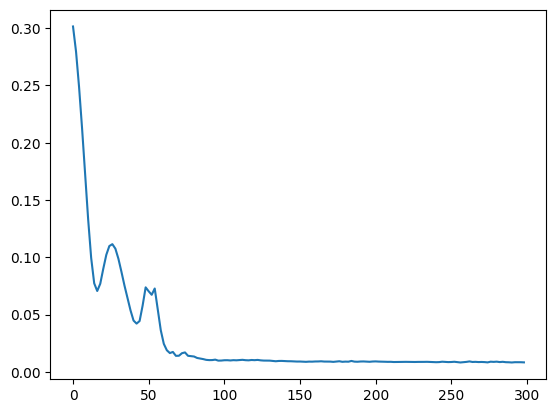

In [50]:
plt.plot(df['epoch'], df['loss'])
plt.show()